# MgII_uniformB_v2

In [1]:
import os
import os.path
import sys

In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.signal
import astropy.io.fits

In [3]:
%matplotlib inline

In [4]:
# Data directory
jobroot = os.path.expanduser("/glade/p/hao/radmhd/egeland/MgII_uniformB_v2")
# B vector mapping
Bmap = np.load(os.path.join(jobroot, 'uniformB.npy'))

In [5]:
# Get coordinate axes
testfile = os.path.join(jobroot, "B_0000", 'Stokes.fits')
hdul = astropy.io.fits.open(testfile)
hdul.info()
stokes = hdul['PRIMARY'].data
L = hdul['WCS-TAB'].data['WAVELENGTH'][0]
th = hdul['WCS-TAB'].data['THETA'][0]
ph = hdul['WCS-TAB'].data['PHI'][0]
I = stokes[0,0,0]

Filename: /glade/p/hao/radmhd/egeland/MgII_uniformB_v2/B_0000/Stokes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (1094, 4, 72, 18)   float64   
  1  WCS-TAB       1 BinTableHDU     24   1R x 4C   [18D, 18D, 72D, 1094D]   


In [6]:
stokes.shape

(18, 72, 4, 1094)

In [7]:
N_th, N_ph, N_stokes, N_L = stokes.shape

k region ixs: 439 475 496 518 553
k region L: 279.5834939259173 279.6204990626851 279.63517676298795 279.64985600428076 279.6868787114122
h region ixs: 886 919 939 958 992
h region L: 280.31303564100995 280.3395776465627 280.3530542082255 280.3664036398547 280.3930842034818
hk center ix: 843
hk center L: 279.9941154856067
hk center peak ix 846
hk center peak: 280.0306028104738


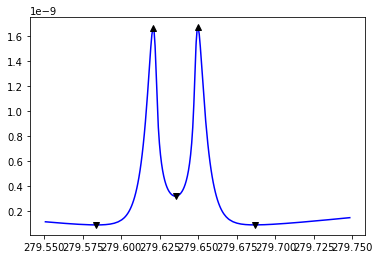

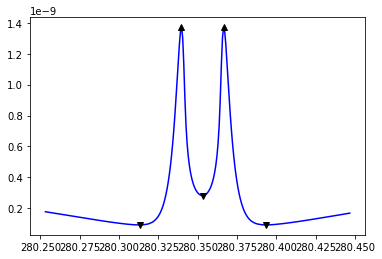

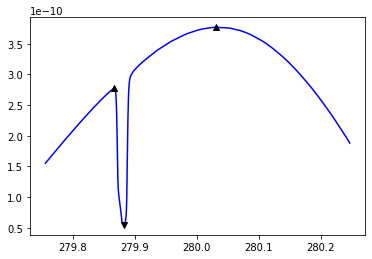

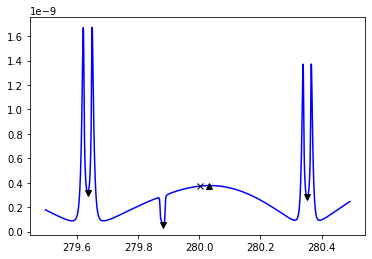

In [8]:
# Functions to define line regions based on minima/maxima

def ordered_extrema(x):
    """Returns min/max extrema indices ordered from least/greatest ascending/descending"""
    ix_mins = scipy.signal.argrelmin(x)[0]
    ix_maxs = scipy.signal.argrelmax(x)[0]
    order_mins = np.argsort(x[ix_mins])
    order_maxs = np.argsort(x[ix_maxs])[::-1]
    return ix_mins[order_mins], ix_maxs[order_maxs]

def profile_extrema(x, ix_center=None, dist_thresh=5):
    """Find the first min/max points away from the center of a region"""
    # TODO: remove dist_thresh hack that prevents extrema very near center from being selected
    #       use amplitude, e.g. "biggest thing to left and biggest thing to right"
    if ix_center is None:
        ix_center = int(np.floor((x.size - 1)/2))
    center = x[ix_center]    
    order_mins, order_maxs = ordered_extrema(x)
    all_extrema = np.append(order_mins, order_maxs)
    dist = all_extrema - ix_center
    
    left = dist < -dist_thresh
    right = dist > +dist_thresh
    first_left = all_extrema[left][np.argmin(np.abs(dist[left]))]
    first_right = all_extrema[right][np.argmin(np.abs(dist[right]))]
    left_right = [first_left, first_right]
    ix_min = left_right[np.argmin(x[left_right])]
    ix_max = left_right[np.argmax(x[left_right])]
    themin = x[ix_min]
    themax = x[ix_max]

    if center < themin and center < themax:
        ix_min = ix_center
    elif center > themin and center > themax:
        ix_max = ix_center

    return ix_min, ix_max

def build_regions(L, I, Lmin, Lmax):
    """Find the min/max points in intensity"""
    sel = (L > Lmin) & (L < Lmax)
    
    fig, ax = plt.subplots()
    ax.plot(L[sel], I[sel], 'b-')
    
    ix_sel_min = np.where(sel)[0][0]
    ix_mins, ix_maxs = ordered_extrema(I[sel])
    ix_mins += ix_sel_min
    ix_maxs += ix_sel_min
    ax.plot(L[ix_mins], I[ix_mins], 'kv')
    ax.plot(L[ix_maxs], I[ix_maxs], 'k^')
    return sorted(ix_mins), sorted(ix_maxs)

# Define all the important inflection points in the intensity
ix_mins, ix_maxs = build_regions(L, I, 279.55, 279.75)
ix_k3v, ix_k, ix_k3r = ix_mins
L_k3v, L_k, L_k3r = L[ix_mins]
ix_k2v, ix_k2r = ix_maxs
L_k2v, L_k2r = L[ix_maxs]
print("k region ixs:", ix_k3v, ix_k2v, ix_k, ix_k2r, ix_k3r)
print("k region L:", L_k3v, L_k2v, L_k, L_k2r, L_k3r)

ix_mins, ix_maxs = build_regions(L, I, 280.25, 280.45)
ix_h3v, ix_h, ix_h3r = ix_mins
L_h3v, L_h, L_h3r = L[ix_mins]
ix_h2v, ix_h2r = ix_maxs
L_h2v, L_h2r = L[ix_maxs]
print("h region ixs:", ix_h3v, ix_h2v, ix_h, ix_h2r, ix_h3r)
print("h region L:", L_h3v, L_h2v, L_h, L_h2r, L_h3r)

ix_mins, ix_maxs = build_regions(L, I, 279.75, 280.25)
L_hk = (L[ix_h] + L[ix_k]) / 2
ix_hk = np.argmin(np.abs(L - L_hk))
ix_hkp = ix_maxs[1]
ix_s = ix_mins[0]
L_hkp = L[ix_hkp]
print("hk center ix:", ix_hk)
print("hk center L:", L_hk)
print("hk center peak ix", ix_hkp)
print("hk center peak:", L_hkp)

def sel_region(L, region):
    """Define line/core regions based on critical points in intensity found above"""
    if region == 'all':
        sel = (L > 250) # all Mg II wings
    elif region == 'hk':
        dL = 1.; sel = (L > (L_hk - dL/2) ) & (L < (L_hk + dL/2)) # both cores; 1 nm
    elif region == 'k':
        dL = 0.2; sel = (L > (L_k - dL/2)) & (L < (L_k + dL/2)) # Mg II k; 0.2 nm
    elif region == 'k3':
        sel = (L > L_k3v) & (L < L_k3r)
    elif region == 'h':
        dL = 0.2; sel = (L > (L_h - dL/2)) & (L < (L_h + dL/2)) # Mg II h; 0.2 nm
    elif region == 'h3':
        sel = (L > L_h3v) & (L < L_h3r)
    return sel

sel_region(L, 'hk');

# Examine the region between h and k.  The maximum is not at the midpoint!
Lsel = sel_region(L, 'hk')
fig, ax = plt.subplots()
ax.plot(L[Lsel], stokes[0,0,0][Lsel], 'b-')
ax.plot(L[ix_k], stokes[0,0,0][ix_k], 'kv') # k core
ax.plot(L[ix_h], stokes[0,0,0][ix_h], 'kv') # h core
ax.plot(L[ix_s], stokes[0,0,0][ix_s], 'kv') # subordinate
ax.plot(L[ix_hk], stokes[0,0,0][ix_hk], 'kx') # midpoint between k and h
ax.plot(L[ix_hkp], stokes[0,0,0][ix_hkp], 'k^') # max intensity between k and h reversals

[[2.00000000e-02 3.00000000e+01 0.00000000e+00]
 [2.51785082e-02 3.00000000e+01 0.00000000e+00]
 [3.16978638e-02 3.00000000e+01 0.00000000e+00]
 [3.99052463e-02 3.00000000e+01 0.00000000e+00]
 [5.02377286e-02 3.00000000e+01 0.00000000e+00]
 [6.32455532e-02 3.00000000e+01 0.00000000e+00]
 [7.96214341e-02 3.00000000e+01 0.00000000e+00]
 [1.00237447e-01 3.00000000e+01 0.00000000e+00]
 [1.26191469e-01 3.00000000e+01 0.00000000e+00]
 [1.58865647e-01 3.00000000e+01 0.00000000e+00]
 [2.00000000e-01 3.00000000e+01 0.00000000e+00]
 [2.51785082e-01 3.00000000e+01 0.00000000e+00]
 [3.16978638e-01 3.00000000e+01 0.00000000e+00]
 [3.99052463e-01 3.00000000e+01 0.00000000e+00]
 [5.02377286e-01 3.00000000e+01 0.00000000e+00]
 [6.32455532e-01 3.00000000e+01 0.00000000e+00]
 [7.96214341e-01 3.00000000e+01 0.00000000e+00]
 [1.00237447e+00 3.00000000e+01 0.00000000e+00]
 [1.26191469e+00 3.00000000e+01 0.00000000e+00]
 [1.58865647e+00 3.00000000e+01 0.00000000e+00]
 [2.00000000e+00 3.00000000e+01 0.000000

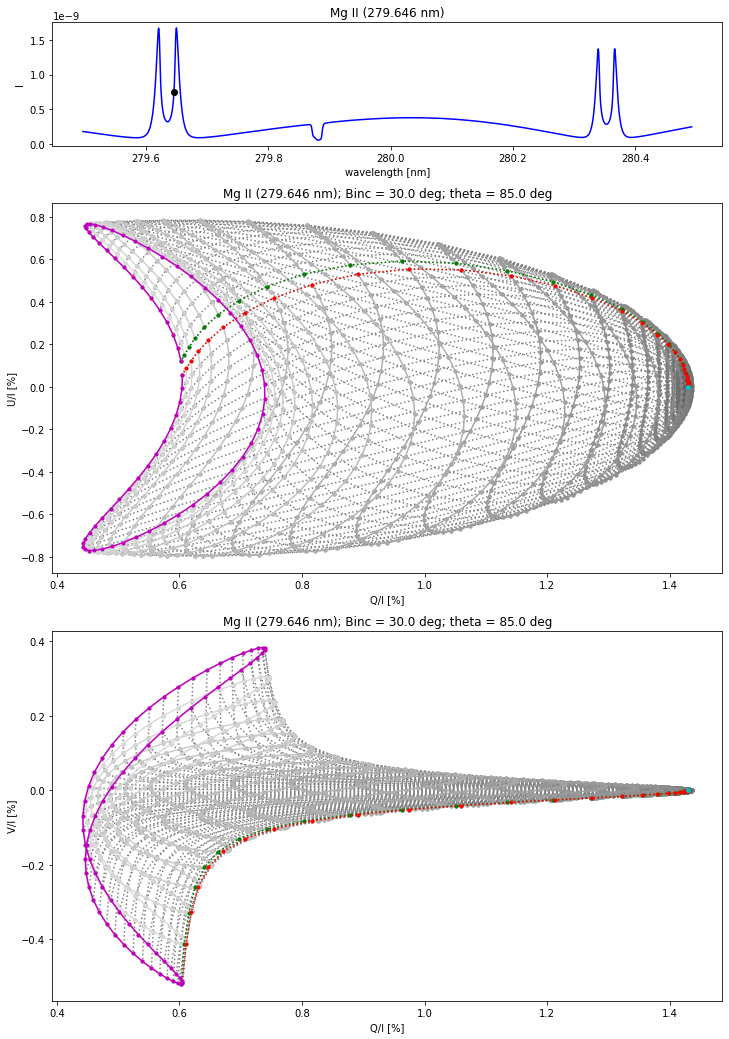

In [9]:
# Make a Hanle diagram

# Wavelength selection
ix_wav = ix_k + 15
L_wav = L[ix_wav]
Lsel = sel_region(L, 'hk')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,18), gridspec_kw=dict(height_ratios=(1, 3, 3)))
ax1.plot(L[Lsel], stokes[0,0,0][Lsel], 'b-')
ax1.plot(L_wav, stokes[0,0,0][ix_wav], 'ko')
ax1.set_ylabel('I')
ax1.set_xlabel('wavelength [nm]')
ax1.set_title(f"Mg II ({L_wav:0.3f} nm)")

# B vector selection
N_jobs = Bmap.shape[0]
iB = 6 # starting point; 0 = 0, 6 = 30, 12 = 60, 18 = 90
N_B = 41
N_Binc = 37
#Bsel = [x for x in range(iB, N_jobs, N_B)] # selection of constant |B|
Bsel = [x for x in range(iB*N_B, N_B*(iB + 1), 1)] # selection of constant Binc
print(Bmap[Bsel])
print(len(Bsel))
Binc = Bmap[Bsel][0][1]

# LOS selection
ix_th = 17 # 0 = 0, 6 = 30, 12 = 60, 17 = 85

Q = np.zeros((N_B, N_ph))
U = np.zeros((N_B, N_ph))
V = np.zeros((N_B, N_ph))

# pick out the data and put in Q, U arrays
for i, ix_B in enumerate(Bsel):
    fitsfile = os.path.join(jobroot, f"B_{ix_B:04d}", 'Stokes.fits')
    hdul = astropy.io.fits.open(fitsfile)
    stokes = hdul['PRIMARY'].data
    I = stokes[ix_th, :, 0, ix_wav]
    Q[i] = stokes[ix_th, :, 1, ix_wav] / I * 100
    U[i] = stokes[ix_th, :, 2, ix_wav] / I * 100
    V[i] = stokes[ix_th, :, 3, ix_wav] / I * 100

# Make plot
def plot_hanle(ax, p1, p2, label1, label2):
    #fig, ax = plt.subplots(figsize=(12,8))
    cmap_B = plt.get_cmap('gray')
    cmap_az = 'gray' #plt.get_cmap('inferno')

    # Lines of constant azimuth
    for i in range(N_ph):
        ax.plot(p1[:, i], p2[:, i], '.:', c=cmap_az)

    # Lines/colors of constant field
    for i in range(N_B):
        B = Bmap[i][0]
        ax.plot(p1[i], p2[i], '.-', c=cmap_B(0.9*(i/N_B)))

    # Color azimuths 0 and 355
    ax.plot(p1[:, 0], p2[:, 0], '.:', c='g')
    ax.plot(p1[:, -1], p2[:, -1], '.:', c='r')

    # Color min/max field
    ax.plot(p1[0], p2[0], '.-', c='c')
    ax.plot(p1[-1], p2[-1], '.-', c='m')

    # Limits and labels
    ax.set_xlabel(label1 + ' [%]')
    ax.set_ylabel(label2 + ' [%]')
    ax.set_title(f"Mg II ({L_wav:0.3f} nm); Binc = {Binc:0.1f} deg; theta = {th[ix_th]:0.1f} deg")
    
plot_hanle(ax2, Q, U, 'Q/I', 'U/I')
plot_hanle(ax3, Q, V, 'Q/I', 'V/I')
plt.savefig('hanle_diag.pdf', bbox_inches='tight')
